In [ ]:
# The hardest part of a Trading Strategy/Machine Learning is minimizing Overfitting. 

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score # pip install scikit-learn
import yfinance_fix

In [ ]:
TICKER = "SPY"
INTERVAL = "1d"
PERIOD = "730d" if INTERVAL == "1h" else "max"
MACD_FAST = 12 # MACD
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14 # MFI
OVERBROUGHT = 70
OVERSOLD = 30 
BB_LENGTH = 20 # BB
STD_DEV = 2
RSI_LENGTH = 14 # RSI
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30
STRATEGY = ['Volume_Change', 'Close_Change' , 'High_Change', 'Low_Change', 'Open_Change', "MACD_HIST", "MFI", "BB", "RSI"]
SHIFT_RANGE = range(1, 120)
SHIFT = 1
OPTIMAL_SHIFT = None
LOOKBACK = 10000
TRAIN_SIZE = .7 # Train Test Split

# --- (1) Daten herunterladen ---
def get_data(ticker=TICKER, interval=INTERVAL, lookback=LOOKBACK):
    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)

    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    for c in df.columns:
        df[f"{c}_Change"] = df[f"{c}"].pct_change() * 100

    subset = df.iloc[-lookback:,:]

    plt.figure()
    plt.plot(subset["Close"])
    plt.title(f"Price Movements for {ticker} during Study")
    
    return df.iloc[-lookback:, :].dropna()

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

def add_MFI(df, length = MFI_LENGTH):
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
    df["BB_STD"] = df["Close"].rolling(window=length).std()
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
    df["BB"] = ((df["Close"] - df["Lower Band"])/(df["Upper Band"] - df["Lower Band"]))

    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    price_change = df["Close"].diff()
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()
    rs = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100/(1+rs))

    return df.dropna()


# --- (3) Add Target ---
def add_target(df, shift=SHIFT):
    df = df.copy()
    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1
    return df.dropna().reset_index(drop=True)

# --- (4) Generate Logistic Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    subset = df[features + [target]].replace([np.inf, -np.inf], np.nan).dropna()

    if len(subset) < 10:
        raise ValueError("Too few rows after cleaning.")

    subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)

    X = sm.add_constant(subset[features])
    y = subset[target]
    
    model = sm.Logit(y, X).fit(disp=0)
    y_pred_prob = model.predict(X)

    df = df.loc[subset.index]
    df["Prediction"] = (y_pred_prob > 0.5).astype(int)

    return df, y, y_pred_prob

# --- (5) Analyze Logistic Regression Output ---
def add_confusion_matrix(df):
    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure()
    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

# Area Under the Curve Plot - ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(y_true, y_scores, title=f"ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_prob):
    plt.figure()
    plt.hist(y_pred_prob, bins=50, color="grey")
    plt.title("Distribution of Logistic Predictions")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --- (6) Optimize for AUC (With Shift Range) ---
def explore_shift_auc(df_raw):
    print(f" Exploring AUC over SHIFT range for {TICKER} on {INTERVAL} interval\n")
    results = []

    for shift in SHIFT_RANGE:
        try:
            df = add_target(df_raw.copy(), shift)
            df, y, y_pred_prob = generate_regression_output(df)
            auc_score = roc_auc_score(y, y_pred_prob)
            print(f"Shift: {shift:2d} | AUC {auc_score:.4f}")
            results.append({"Shift": shift, "AUC": auc_score})
        except Exception as e:
            print(f"Shift {shift}: skipped due to error ({e})")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
    return results_df

# --- (7) Add Train Test Split Function ---
def train_test_split(df, train_size=TRAIN_SIZE):
    # Once we have our weights and bias from the training set, we will use it on the testing set
    df = df.sample(frac=1).reset_index(drop=True)

    split = int((len(df) * .7))
    all_rows = int((len(df)))
    test_nr = int((len(df) * .3))
    print(f"Nr. of Rows (All): {all_rows}")
    print(f"Nr. of Training Rows: {split}")
    print(f"Nr. of Testing Rows: {test_nr}")

    train = df.iloc[:split, :]
    test = df.iloc[split:, :] # Our future data, not included in the training of the model
    
    return df, train, test 



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Nr. of Rows (All): 8247
Nr. of Training Rows: 5772
Nr. of Testing Rows: 2474


Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,...,Upper Band,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target
0,91.733818,92.017976,91.733818,91.837773,30016700,-0.120723,-0.022574,0.386815,0.348362,-52.040960,...,92.085825,88.917958,0.888882,0.000000,0.110878,0.205940,0.123764,62.462046,91.913986,1
1,44.286736,44.352680,44.022956,44.136004,481900,0.448690,-0.042491,-0.000028,-0.467417,-33.060147,...,44.577112,41.570531,0.903420,0.197823,-0.000000,0.191774,0.053827,78.083601,44.578777,1
2,54.212341,55.502938,54.124344,54.271006,470510900,-2.234866,-4.995606,-2.277247,-4.895915,29.491083,...,65.119754,53.428793,0.067022,0.000000,1.239269,0.183325,0.866859,17.456447,51.770500,0
3,254.322784,256.084221,253.211749,254.873809,84609200,-0.300940,-0.302375,-0.387280,-0.476122,-6.268992,...,255.923972,246.975084,0.821074,0.000000,0.767670,0.713292,0.449259,61.355746,257.195221,1
4,424.680328,427.583831,423.133685,425.059866,79272700,-0.267422,-0.013341,0.543340,0.534096,1.505176,...,444.866254,402.599033,0.522421,0.000000,1.138733,2.057667,1.842143,52.763260,417.421661,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8242,72.317123,73.019230,71.525653,72.757533,14937800,-1.521128,-0.943852,-0.391164,0.608947,-30.595462,...,76.754465,70.166643,0.326433,0.000000,1.117027,0.615490,0.800135,43.478323,73.121323,1
8243,415.941101,416.655204,415.189434,415.875322,43339300,0.124392,0.144535,0.129159,0.033897,5.134805,...,419.822177,402.617985,0.774411,0.516754,-0.000000,1.067780,0.522141,67.159323,416.974670,1
8244,84.042473,84.427011,83.678535,83.829604,57666800,0.130895,0.432932,0.057473,0.123020,36.804198,...,84.721102,80.023873,0.855526,0.109863,-0.000000,0.330584,0.099074,76.941146,84.694824,1
8245,75.514893,75.731910,73.580905,73.797923,12880700,2.044175,2.046982,0.444387,-0.069121,29.534987,...,82.512856,69.945540,0.443162,1.512733,-0.000000,0.530434,0.910164,36.820392,73.427711,0


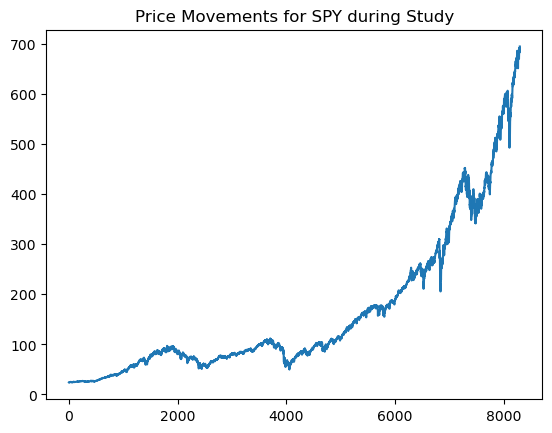

In [ ]:
def make_dataset():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, train, test = train_test_split(df)

    return df, train, test 

df, train, test = make_dataset()
df


 Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC 0.5498
Shift:  2 | AUC 0.5478
Shift:  3 | AUC 0.5373
Shift:  4 | AUC 0.5415
Shift:  5 | AUC 0.5489
Shift:  6 | AUC 0.5300
Shift:  7 | AUC 0.5450
Shift:  8 | AUC 0.5424
Shift:  9 | AUC 0.5447
Shift: 10 | AUC 0.5526
Shift: 11 | AUC 0.5392
Shift: 12 | AUC 0.5429
Shift: 13 | AUC 0.5423
Shift: 14 | AUC 0.5446
Shift: 15 | AUC 0.5329
Shift: 16 | AUC 0.5475
Shift: 17 | AUC 0.5281
Shift: 18 | AUC 0.5502
Shift: 19 | AUC 0.5508
Shift: 20 | AUC 0.5557
Shift: 21 | AUC 0.5445
Shift: 22 | AUC 0.5436
Shift: 23 | AUC 0.5386
Shift: 24 | AUC 0.5457
Shift: 25 | AUC 0.5394
Shift: 26 | AUC 0.5335
Shift: 27 | AUC 0.5436
Shift: 28 | AUC 0.5449
Shift: 29 | AUC 0.5521
Shift: 30 | AUC 0.5450
Shift: 31 | AUC 0.5375
Shift: 32 | AUC 0.5358
Shift: 33 | AUC 0.5542
Shift: 34 | AUC 0.5581
Shift: 35 | AUC 0.5416
Shift: 36 | AUC 0.5502
Shift: 37 | AUC 0.5607
Shift: 38 | AUC 0.5427
Shift: 39 | AUC 0.5367
Shift: 40 | AUC 0.5413
Shift: 41 | AUC 0.5419
S

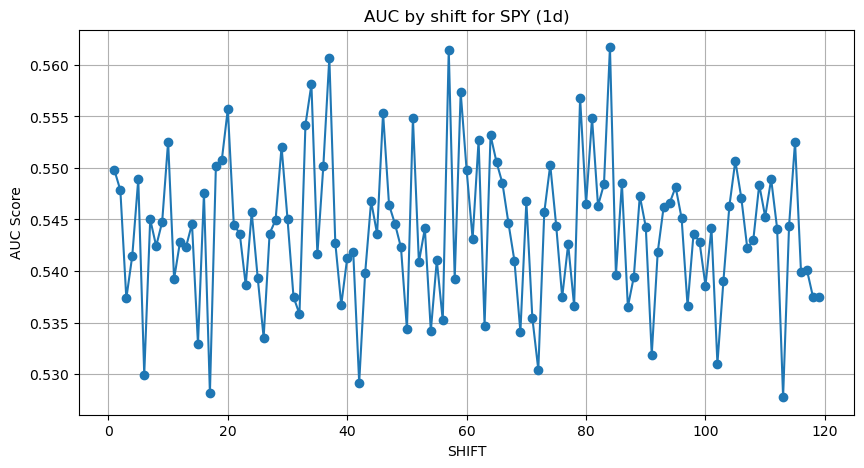


 Optimal SHIFT (Holding Period to Maximize Returns) to optimize AUC: 84

 Running Final Model Analysis with SHIFT = 84


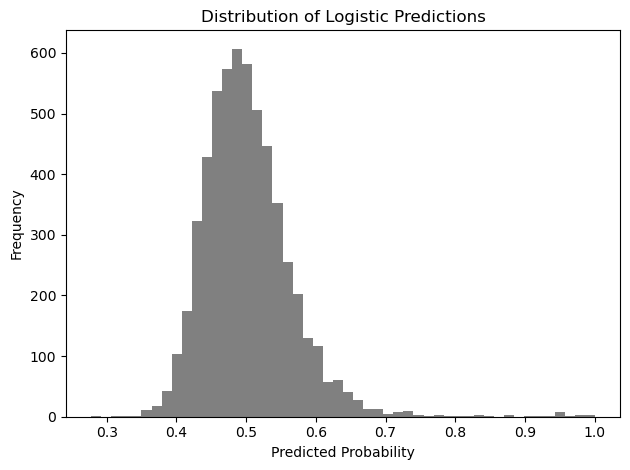

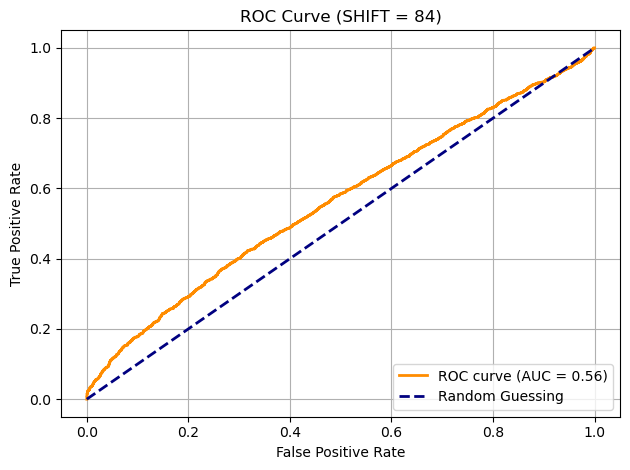

,Shift,AUC
0,84,0.561711
1,57,0.561466
2,37,0.560698
3,34,0.558105
4,59,0.557338
...,...,...
114,72,0.530431
115,6,0.529954
116,42,0.529163
117,17,0.528130


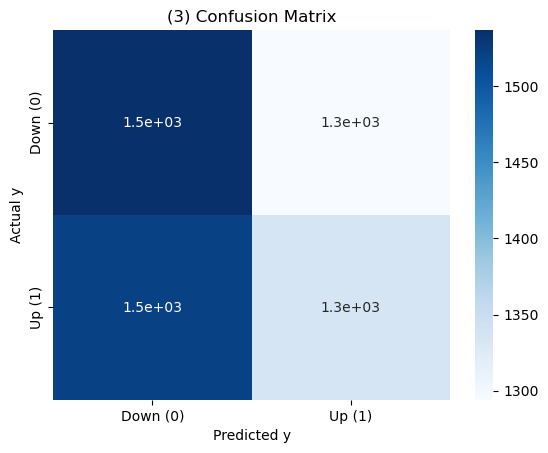

In [ ]:
# Applying the Regression Output Function only to the training Dataset

def train_dataset(df):
    global OPTIMAL_SHIFT

    # Explore AUC over multiple shifts
    results_df = explore_shift_auc(df)
    plot_df = results_df.sort_values(by="Shift")

    # Plot AUC vs. SHIFT 
    plt.figure(figsize=(10,5))
    plt.plot(plot_df["Shift"], plot_df["AUC"], marker="o")
    plt.title(f"AUC by shift for {TICKER} ({INTERVAL})")
    plt.xlabel("SHIFT")
    plt.ylabel("AUC Score")
    plt.grid(True)
    plt.show()

    # What this graphy could possibly guide us is:
    # I would place a trade on the minutely timeframe, I would want to hold my trade for {Optimal Shift} Min/Hour/Days
    # We want to find/see something closer to 0.60, becuase if our cutoff is 0.5, then we are just randomly seeing it 

    # Set optimal shift globally for future studies
    OPTIMAL_SHIFT = int(results_df.iloc[0]["Shift"])
    print(f"\n Optimal SHIFT (Holding Period to Maximize Returns) to optimize AUC: {OPTIMAL_SHIFT}")

    # Final Study with Optimal shift
    print(f"\n Running Final Model Analysis with SHIFT = {OPTIMAL_SHIFT}")
    df_final = add_target(df.copy(), shift=OPTIMAL_SHIFT)
    df_final, y_final, y_pred_prob = generate_regression_output(df_final)

    plot_prediction_distribution(y_pred_prob)
    add_roc_plot(y_final, y_pred_prob, title=f"ROC Curve (SHIFT = {OPTIMAL_SHIFT})")
    add_confusion_matrix(df_final)

    return df, results_df 

df, results_df = train_dataset(train)
results_df 

 Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC 0.5321
Shift:  2 | AUC 0.5372
Shift:  3 | AUC 0.5534
Shift:  4 | AUC 0.5620
Shift:  5 | AUC 0.5423
Shift:  6 | AUC 0.5574
Shift:  7 | AUC 0.5452
Shift:  8 | AUC 0.5405
Shift:  9 | AUC 0.5425
Shift: 10 | AUC 0.5538
Shift: 11 | AUC 0.5319
Shift: 12 | AUC 0.5402
Shift: 13 | AUC 0.5453
Shift: 14 | AUC 0.5466
Shift: 15 | AUC 0.5537
Shift: 16 | AUC 0.5567
Shift: 17 | AUC 0.5584
Shift: 18 | AUC 0.5515
Shift: 19 | AUC 0.5383
Shift: 20 | AUC 0.5587
Shift: 21 | AUC 0.5534
Shift: 22 | AUC 0.5453
Shift: 23 | AUC 0.5545
Shift: 24 | AUC 0.5570
Shift: 25 | AUC 0.5606
Shift: 26 | AUC 0.5398
Shift: 27 | AUC 0.5395
Shift: 28 | AUC 0.5454
Shift: 29 | AUC 0.5495
Shift: 30 | AUC 0.5574
Shift: 31 | AUC 0.5490
Shift: 32 | AUC 0.5599
Shift: 33 | AUC 0.5372
Shift: 34 | AUC 0.5451
Shift: 35 | AUC 0.5579
Shift: 36 | AUC 0.5548
Shift: 37 | AUC 0.5670
Shift: 38 | AUC 0.5431
Shift: 39 | AUC 0.5454
Shift: 40 | AUC 0.5416
Shift: 41 | AUC 0.5536
S

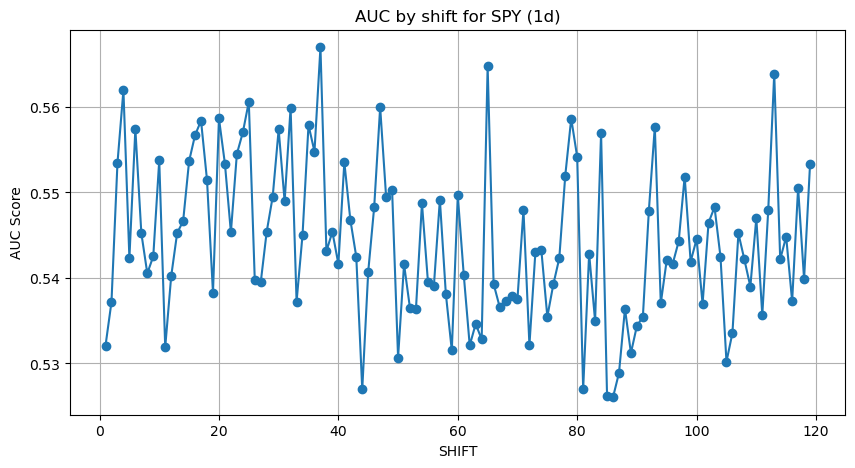


 Optimal SHIFT (Holding Period to Maximize Returns) to optimize AUC: 37

 Running Final Model Analysis with SHIFT = 37


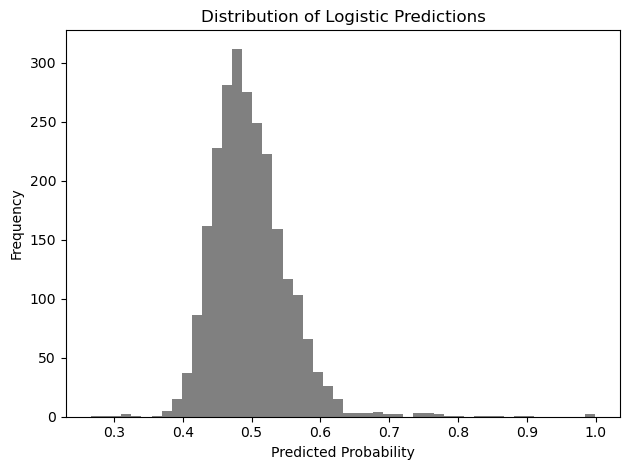

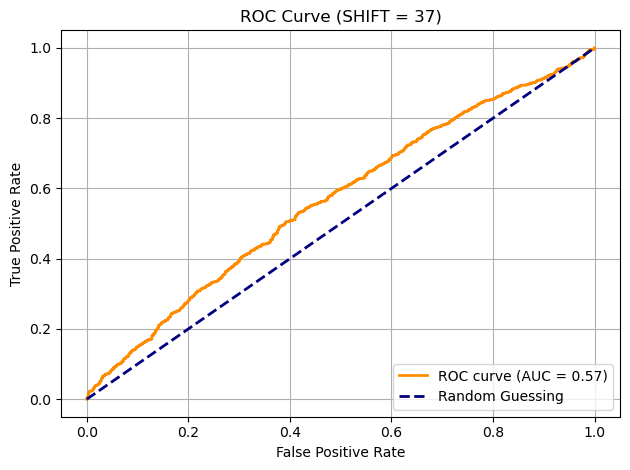

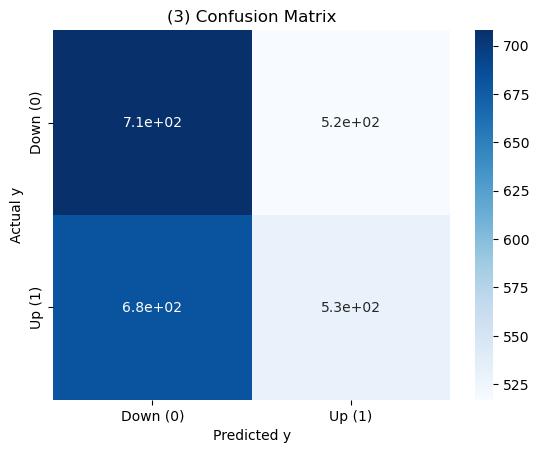

In [ ]:
df, results_df = train_dataset(test)